# Model Training
Welcome to the 'Model Training and Prediction' notebook, a crucial facet of our project's data science pipeline. In this notebook, we offer a meticulous examination of our rigorous model development process. The pipeline starts by accepting training data, followed by fitting three distinct types of models to it: Random Forest, Gradient Boosted Tree, and XGBoost. The initial stages include encoding categorical variables and executing Recursive Feature Elimination (RFE) for feature selection. This is succeeded by the application of genetic algorithms to hyperparameter tuning, operating in tandem with a cross-validation routine. Subsequently, the best model is selected based on the highest F1 score, indicating the balance between precision and recall. Finally, the selected model is utilized to predict the outcomes for the current week's round of NRL matches. This process is iterative and cyclical, with the potential for revisiting earlier stages based on the model's performance. Let us proceed with this in-depth exploration.

## Set up Environment
This code segment is setting up the environment for the model training pipeline. It begins by importing sys and pathlib - Python libraries used for managing system parameters and file paths, respectively.

The code then updates the system path to include the "functions" directory. This allows for the import of custom modules `modelling_functions`, `model_properties`, and `training_config` which are stored in this directory. These modules contain custom functions and configuration settings that are critical for the later stages of data preprocessing, model training, and prediction.

Following this, the `project_root` variable is defined. This is achieved by using the pathlib library to establish the root directory of the project.

Finally, the `db_path` variable is constructed. This is the relative path to the SQLite database "footy-tipper-db.sqlite", which is located in the "data" directory of the project root. This path will be used for database connectivity throughout the pipeline.

In [1]:
# import libraries
import os
import sys
import pathlib

cwd = os.getcwd()

# get the parent directory
parent_dir = os.path.dirname(cwd)

# add the parent directory to the system path
sys.path.insert(0, parent_dir)

# Get to the root directory
project_root = pathlib.Path().absolute().parent

# import functions from common like this:
from pipeline.common.model_training import (
    training_config as tc,
    modelling_functions as mf,
    model_properties as mp
)

from pipeline.common.model_prediciton import prediction_functions as pf

## Get data
Our process starts by establishing the root directory of the project and constructing the relative path to the 'footy-tipper-db.sqlite' database located within the 'data' directory. We then connect to this SQLite database and use a SQL query housed in the 'footy_tipping_data.sql' file, found in the 'sql' directory, to extract the required data. This data is loaded into a pandas DataFrame, footy_tipping_data, serving as the basis for our subsequent modeling activities. Upon successful extraction of the data, we ensure the database connection is closed, maintaining good coding practice and resource management.

In [2]:
data = mf.get_training_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/training_data.sql')

data

,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.018111e+10,1.0,Round 1,1.0,Final,1.520540e+09,1.520500e+09,Netstrata Jubilee Stadium,Sydney,14457.0,...,0.0,0.0,1498.872010,1510.437335,-11.565325,0.472175,0.496856,0.030969,-0.024680,2.821392
1,2.018111e+10,1.0,Round 1,2.0,Final,1.520618e+09,1.520579e+09,McDonald Jones Stadium,Newcastle,23516.0,...,0.0,0.0,1484.765189,1496.167714,-11.402525,0.472402,0.496629,0.030969,-0.024227,4.537350
2,2.018111e+10,1.0,Round 1,3.0,Final,1.520622e+09,1.520586e+09,1300SMILES Stadium,Townsville,15900.0,...,0.0,0.0,1506.231994,1503.247565,2.984429,0.492462,0.476569,0.030969,0.015894,2.150093
3,2.018111e+10,1.0,Round 1,4.0,Final,1.520699e+09,1.520660e+09,Accor Stadium,Sydney,18243.0,...,0.0,0.0,1493.847787,1500.971788,-7.124001,0.478367,0.490664,0.030969,-0.012298,-2.314489
4,2.018111e+10,1.0,Round 1,5.0,Final,1.520698e+09,1.520669e+09,Other,Perth,38824.0,...,0.0,0.0,1490.494215,1483.489715,7.004500,0.498066,0.470965,0.030969,0.027100,1.063154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,2.024111e+10,19.0,Round 19,1.0,Final,1.720727e+09,1.720691e+09,Kayo Stadium,Redcliffe,10023.0,...,-16.0,10.0,1496.661993,1497.032388,-0.370395,0.487784,0.481246,0.030969,0.006538,-0.272191
1323,2.024111e+10,19.0,Round 19,2.0,Final,1.720814e+09,1.720778e+09,PointsBet Stadium,Sydney,10912.0,...,34.0,-38.0,1508.922544,1459.452887,49.469657,0.558894,0.413875,0.027231,0.145019,12.820360
1324,2.024111e+10,19.0,Round 19,3.0,Final,1.720892e+09,1.720856e+09,Cbus Super Stadium,Gold Coast,16670.0,...,8.0,52.0,1495.657244,1467.374847,28.282397,0.529663,0.443106,0.027231,0.086557,7.453442
1325,2.024111e+10,19.0,Round 19,4.0,Final,1.720899e+09,1.720863e+09,Suncorp Stadium,Brisbane,34224.0,...,30.0,-38.0,1499.043243,1493.724304,5.318939,0.495717,0.473314,0.030969,0.022402,4.162522


## Modelling

During the modeling phase, the `train_and_select_best_model` function, part of our `modelling_functions` module, is invoked. This function initiates the training of Poisson models specifically designed for predicting the scores of the home and away teams. It takes as input the footy tipping data, predictor variables, the outcome variable, and several configuration settings like whether to use Recursive Feature Elimination (RFE), the number of cross-validation folds, and the optimization metric, all sourced from the `training_config` module.

The function first identifies categorical columns in the feature set for one-hot encoding, creating dummy variables for categorical features. Depending on the choice of using RFE, a feature elimination step may be included in the pipeline. Each model subsequently undergoes hyperparameter tuning using a genetic algorithm, facilitated by the `GASearchCV` function.

All the models are then trained and evaluated through cross-validation. The best models for predicting home and away scores are selected based on superior performance on the chosen optimization metric. The selected models, encapsulated in pipelines with pre-processing steps and hyperparameter tuning, are now ready for the prediction phase.

The trained models are saved using the `save_models` function for future use, ensuring that the prediction process can be efficiently replicated and scaled.

### Test Modelling Data Preparation
First, because we want to understand how effective our simulations are without creating more load on the model cross-validation, we will split the data into training and testing sets. This will allow us to evaluate the model's interaction with each other on unseen data more easily.

In [3]:
# Set the random seed for reproducibility
random_seed = 42

# Define the test size proportion
test_size = 0.2

# Randomly shuffle the DataFrame and split
training_data = data.sample(frac=1 - test_size, random_state=random_seed)
test_data = data.drop(training_data.index)

### Poisson Modelling
The Poisson model is a statistical model that is used to predict the number of events occurring within a fixed interval of time or space. In the context of sports, the Poisson model can be used to predict the number of goals or points scored by each team in a match. In this section, we will implement a Poisson model to predict the number of points scored by each team in a match. We will then use these predictions to calculate the expected match outcome.

#### Home Modelling

In [4]:
home_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_home',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)


Model training: LGBMRegressor
gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	100   	-7.0454	0.724502   	-5.74851   	-8.33619   
1  	134   	-6.54683	0.538011   	-5.83685   	-7.66533   
2  	136   	-6.07487	0.273969   	-5.70987   	-6.91389   
3  	143   	-5.86751	0.0915947  	-5.614     	-6.11203   
4  	138   	-5.80607	0.0855405  	-5.61397   	-6.01573   
5  	138   	-5.73885	0.0799953  	-5.61397   	-5.90842   
6  	147   	-5.6765 	0.0525563  	-5.61397   	-5.83685   
7  	128   	-5.64652	0.0469902  	-5.6105    	-5.84987   
8  	125   	-5.61993	0.0244323  	-5.60773   	-5.84987   
9  	135   	-5.61411	0.00148348 	-5.60773   	-5.62519   
10 	156   	-5.61378	0.00106502 	-5.60772   	-5.61397   
11 	146   	-5.61341	0.00176197 	-5.60772   	-5.61397   
12 	138   	-5.61292	0.00231812 	-5.60772   	-5.61397   
13 	136   	-5.61157	0.00298883 	-5.60771   	-5.61397   
14 	141   	-5.60957	0.00280585 	-5.60771   	-5.61397   
15 	140   	-5.60832	0.00520513 	-5.60771   	-5.65974   
16 	146   	-5.60772

##### Feature Imprtance

In [5]:
preprocessor = home_model.named_steps['one_hot_encoder']
encoded_feature_names = preprocessor.get_feature_names_out(tc.predictors)

# Get the top 20 feature importances
top_20_features = mp.get_feature_importances(home_model, encoded_feature_names)
print(top_20_features)

                                    feature  importance
197             remainder__season_form_away           5
241             remainder__season_form_home           2
160               remainder__punt_odds_diff           2
161             remainder__line_amount_diff           2
267  remainder__team_head_to_head_odds_home           2
266        remainder__team_line_amount_away           2
243          remainder__tries_conceded_home           2
167          remainder__home_loss_rate_home           1
162             remainder__recent_form_diff           1
221      remainder__avg_tries_conceded_away           1
182                    remainder__wins_away           0
177                remainder__elo_draw_prob           0
176                 remainder__matchup_form           0
175                   remainder__start_hour           0
174                remainder__position_diff           0
173      remainder__avg_goals_conceded_home           0
179                  remainder__post_origin     

#### Away Team Modelling

In [6]:
away_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_away',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)


Model training: LGBMRegressor
gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	100   	-6.6678	0.656125   	-5.35496   	-7.96104   
1  	137   	-6.05307	0.431279   	-5.35496   	-7.27056   
2  	131   	-5.70353	0.248722   	-5.3368    	-6.60102   
3  	142   	-5.50986	0.157599   	-5.33177   	-5.9147    
4  	133   	-5.40803	0.0789117  	-5.33177   	-5.69442   
5  	142   	-5.36152	0.0230605  	-5.33499   	-5.47211   
6  	139   	-5.34967	0.00908758 	-5.32297   	-5.36656   
7  	140   	-5.34362	0.0081736  	-5.32297   	-5.35946   
8  	142   	-5.33719	0.00710509 	-5.32297   	-5.35513   
9  	139   	-5.33427	0.00578822 	-5.32234   	-5.34776   
10 	135   	-5.33008	0.00614244 	-5.32084   	-5.34248   
11 	130   	-5.32934	0.0213306  	-5.31704   	-5.53325   
12 	142   	-5.32394	0.00395074 	-5.31704   	-5.34248   
13 	139   	-5.32249	0.0022941  	-5.31704   	-5.33826   
14 	140   	-5.32192	0.00201329 	-5.31704   	-5.32297   
15 	142   	-5.32135	0.00328685 	-5.31704   	-5.34293   
16 	152   	-5.31971

##### Feature Importance

In [7]:
# Get the names of the features after preprocessing (one-hot encoding)
preprocessor = away_model.named_steps['one_hot_encoder']
encoded_feature_names = preprocessor.get_feature_names_out(tc.predictors)

# Get the top 20 feature importances
top_20_features = mp.get_feature_importances(away_model, encoded_feature_names)
print(top_20_features)

                                    feature  importance
160               remainder__punt_odds_diff          12
197             remainder__season_form_away          11
212          remainder__avg_points_for_away          10
162             remainder__recent_form_diff           9
180        remainder__home_ground_advantage           9
264  remainder__team_head_to_head_odds_away           7
241             remainder__season_form_home           7
161             remainder__line_amount_diff           7
164             remainder__recent_form_home           6
248            remainder__players_used_home           5
244               remainder__goals_for_home           5
243          remainder__tries_conceded_home           5
206   remainder__average_losing_margin_away           5
238               remainder__loss_rate_home           5
208                remainder__win_rate_away           5
154                encoder__game_day_Sunday           4
256       remainder__points_difference_home     

### Example Match Simulation
In this section, we will simulate a match between two teams using the Poisson model. We will generate the expected number of points scored by each team and use these predictions to determine the match outcome. We will then compare the predicted outcome with the actual outcome to evaluate the accuracy of the Poisson model.

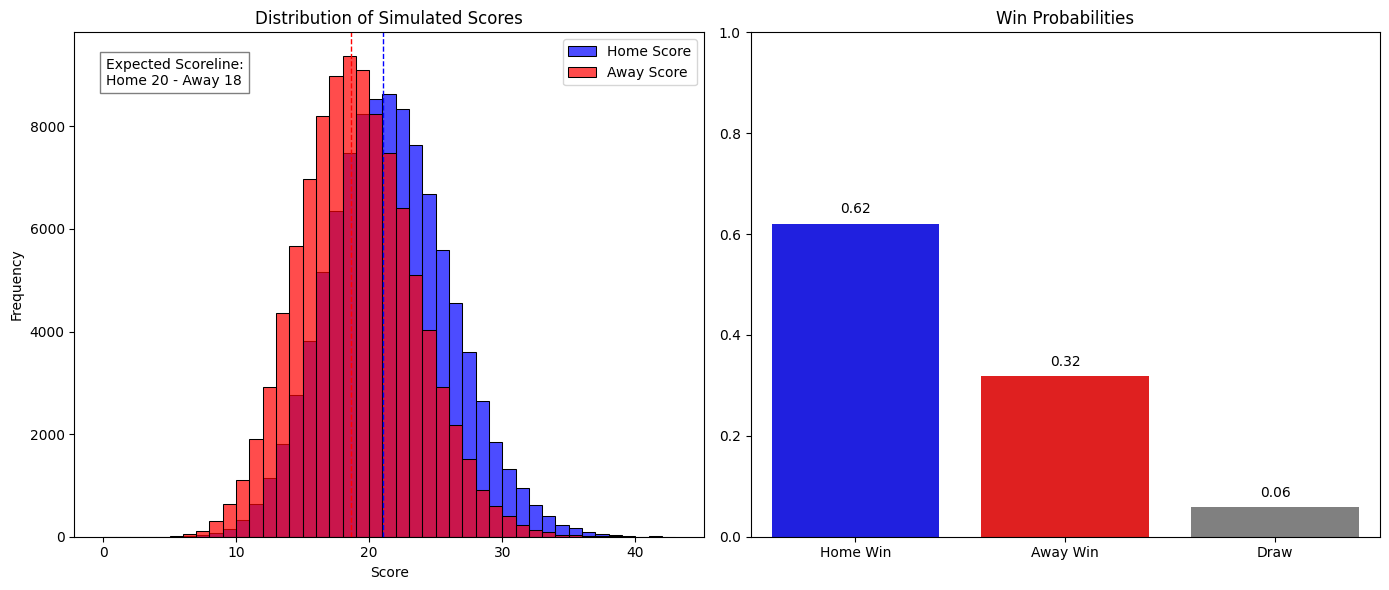

In [8]:
# Example usage with test_data
mp.plot_sampling_distributions(home_model, away_model, test_data, tc.predictors)

###  Evaluation
The evaluation phase involves predicting the outcomes of an unseen set of random NRL matches using the selected home and away models.

This section is only to be used in development and testing at the moment.
#### Classification Report

Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

    home_win       0.76      0.87      0.81       150
    away_win       0.79      0.65      0.71       115
        draw       0.00      0.00      0.00         0

   micro avg       0.77      0.77      0.77       265
   macro avg       0.52      0.51      0.51       265
weighted avg       0.78      0.77      0.77       265



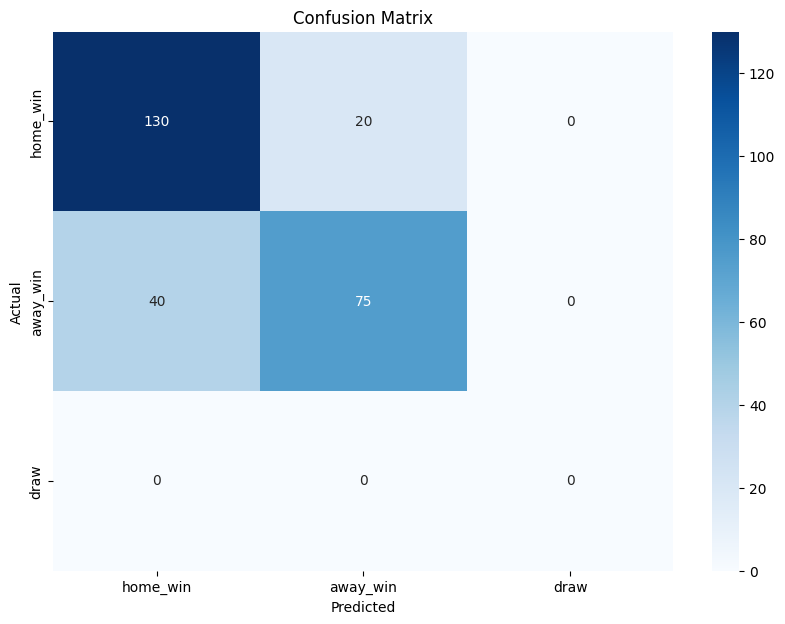

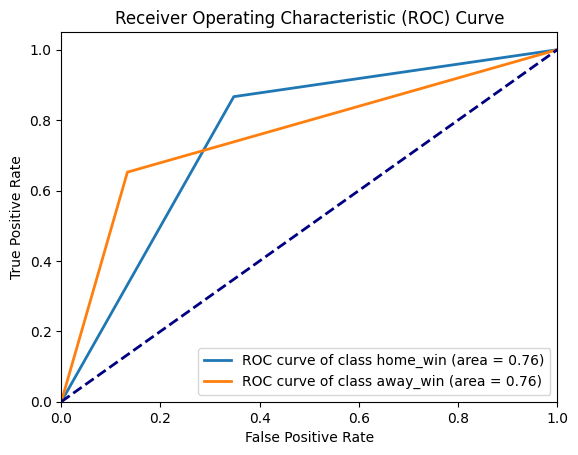

In [9]:
# Evaluate the models on the test data
result_df = mp.evaluate_models(home_model, away_model, test_data, tc.predictors)

#### Expected Scores

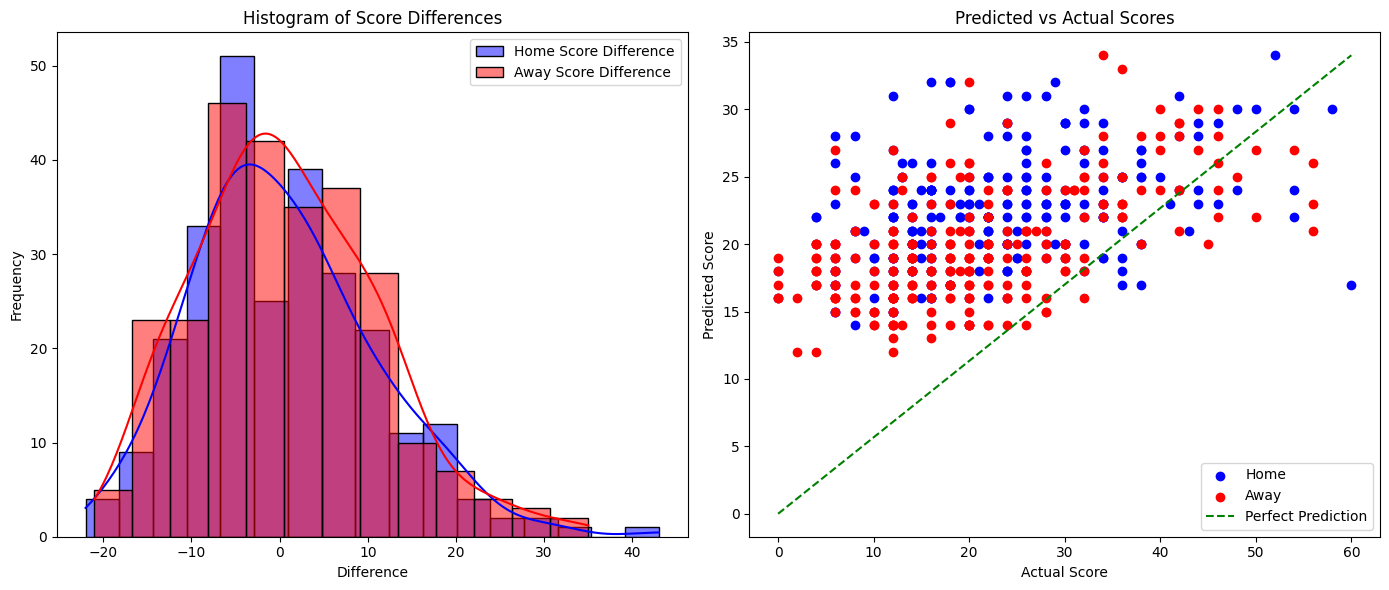

{'mae_home': 8.181132075471698,
 'mae_away': 8.20754716981132,
 'rmse_home': 10.42203760905363,
 'rmse_away': 10.344445232578272,
 'r2_home': 0.15225389972141745,
 'r2_away': 0.25854718522218223}

In [10]:
mp.evaluate_score_predictions(result_df)

## Save Models
The `save_models` function stores Pipeline objects to the disk. This allows for easy retrieval and reuse in future model prediction tasks, without the need to retrain these components. The objects are stored in a designated 'models' directory under the project root path, ensuring organized and consistent storage.

In [11]:
mf.save_models(home_model, 'home_model', project_root)
mf.save_models(away_model, 'away_model', project_root)

Pipeline saved to models/home_model.pkl
Pipeline saved to models/away_model.pkl


## Match Simulation and Prediction
The final stage of the pipeline involves predicting the outcomes of the current week's NRL matches. This is achieved by loading the saved models from the 'models' directory and utilizing them to simulate the matches. The predictions are then stored in a DataFrame, which is subsequently written back to the SQLite database. This data can be accessed by the front-end application to display the predicted outcomes to the users.

In [12]:
# Load the models
home_model = pf.load_models('home_model', project_root)
away_model = pf.load_models('away_model', project_root)

# Load this week's game data
inference_data = pf.get_inference_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/inference_data.sql')
inference_data

home_model model pipeline loaded
away_model model pipeline loaded
Getting inference data...


,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.024111e+10,20.0,Round 20,1.0,Pre Game,1.721419e+09,1.721383e+09,GIO Stadium,Canberra,None,...,1.0,-5.0,1466.742144,1490.804290,-24.062145,0.453863,0.513208,0.032929,-0.059345,1.344333
1,2.024111e+10,20.0,Round 20,2.0,Pre Game,1.721488e+09,1.721452e+09,Industree Group Stadium,Gosford,None,...,52.0,-38.0,1493.768531,1441.920648,51.847883,0.567919,0.414840,0.017241,0.153079,10.441167
2,2.024111e+10,20.0,Round 20,3.0,Pre Game,1.721497e+09,1.721461e+09,McDonald Jones Stadium,Newcastle,None,...,16.0,-8.0,1476.159867,1496.484108,-20.324241,0.459049,0.508022,0.032929,-0.048974,0.119033
3,2.024111e+10,20.0,Round 20,4.0,Pre Game,1.721504e+09,1.721468e+09,AAMI Park,Melbourne,None,...,-10.0,20.0,1526.670571,1559.707999,-33.037428,0.441441,0.525630,0.032929,-0.084189,4.270667
4,2.024111e+10,20.0,Round 20,5.0,Pre Game,1.721570e+09,1.721534e+09,BlueBet Stadium,Penrith,None,...,20.0,-30.0,1529.179128,1499.925850,29.253279,0.531011,0.441758,0.027231,0.089254,12.879433
5,2.024111e+10,20.0,Round 20,6.0,Pre Game,1.721578e+09,1.721542e+09,4 Pines Park,Sydney,None,...,-4.0,42.0,1521.779247,1496.042928,25.736320,0.526125,0.446644,0.027231,0.079481,7.557700
6,2.024111e+10,20.0,Round 20,7.0,Pre Game,1.721586e+09,1.721550e+09,Queensland Country Bank Stadium,Townsville,None,...,18.0,-19.0,1501.841680,1509.245624,-7.403943,0.477976,0.491055,0.030969,-0.013078,4.347300


### Prediction Simulation
The `simulate_predictions` function is used to predict the outcomes of the current week's NRL matches. It loads the saved models from the 'models' directory and uses them to simulate the matches. The predictions are then stored in a DataFrame, which is written back to the SQLite database.

In [21]:
import pandas as pd

# Predict match outcomes and scorelines for the inference data
outcomes, margins = pf.predict_match_outcome_and_scoreline_with_bayes(home_model, away_model, inference_data, tc.predictors)
outcome_df = pd.merge(outcomes, margins, on='game_id')
outcome_df

,game_id,home_team_result,home_team_win_prob,home_team_lose_prob,draw_prob,bayes_factor,evidence_strength,predicted_home_score,predicted_away_score,predicted_margin
0,2.024111e+10,Win,0.62711,0.31857,0.05432,1.968516,Anecdotal evidence,24,21,3
1,2.024111e+10,Win,0.96283,0.02686,0.01031,35.846240,Very strong evidence,28,15,13
2,2.024111e+10,Win,0.57939,0.36266,0.05795,1.597612,Anecdotal evidence,21,20,1
3,2.024111e+10,Win,0.53262,0.40858,0.05880,1.303588,Anecdotal evidence,22,20,2
4,2.024111e+10,Win,0.95495,0.03212,0.01293,29.730697,Strong evidence,27,15,12
5,2.024111e+10,Win,0.81867,0.14429,0.03704,5.673782,Moderate evidence,24,19,5
6,2.024111e+10,Win,0.70266,0.24580,0.05154,2.858666,Anecdotal evidence,23,19,4


In [14]:
# Save the predictions to the database
pf.save_predictions_to_db(
    outcome_df, 
    project_root / "data" / "footy-tipper-db.sqlite", 
    project_root / 'pipeline/common/sql/create_table.sql', 
    project_root / 'pipeline/common/sql/insert_into_table.sql'
)

Saving predictions to database...


## Sending Predictions via Email using ChatGPT
In this section, we will use the OpenAI ChatGPT model to generate an email template for sending the predictions to the users. We will use the predictions generated in the previous section and the ChatGPT model to create a personalized email template for each user. The email template will contain the predicted outcomes of the NRL matches for the current week.

In [15]:
from dotenv import load_dotenv
from pipeline.common.model_prediciton import prediction_functions as pf
from pipeline.common.use_predictions import sending_functions as sf

# Now construct the relative path to your SQLite database
db_path = project_root / "data" / "footy-tipper-db.sqlite"
secrets_path = project_root / "secrets.env"
json_path = project_root / "service-account-token.json"

load_dotenv(dotenv_path=secrets_path)

True

In [16]:
import sqlite3
import pandas as pd
# Connect to the SQLite database
con = sqlite3.connect(str(db_path))

# Read SQL query from external SQL file
with open(project_root / 'pipeline/common' / 'sql/prediction_table.sql', 'r') as file:
    query = file.read()

# Execute the query and fetch the results into a data frame
predictions = pd.read_sql_query(query, con)

# Disconnect from the SQLite database
con.close()

predictions

,game_id,home_team_result,team_home,position_home,team_head_to_head_odds_home,team_away,position_away,team_head_to_head_odds_away,home_team_win_prob,home_team_lose_prob,round_id,competition_year,round_name
0,20241112010,Win,Canberra Raiders,11,1.69,New Zealand Warriors,12,2.18,0.62541,0.32048,20,2024,Round 20
1,20241112020,Win,South Sydney Rabbitohs,15,1.32,Wests Tigers,17,3.41,0.96257,0.02683,20,2024,Round 20
2,20241112030,Win,Newcastle Knights,10,2.36,Brisbane Broncos,13,1.60,0.58089,0.35878,20,2024,Round 20
3,20241112040,Win,Melbourne Storm,1,2.10,Sydney Roosters,3,1.75,0.53017,0.40973,20,2024,Round 20
4,20241112050,Win,Penrith Panthers,2,1.21,Dolphins,6,4.45,0.95511,0.03150,20,2024,Round 20
5,20241112060,Win,Manly-Warringah Sea Eagles,7,1.45,Gold Coast Titans,14,2.78,0.81835,0.14453,20,2024,Round 20
6,20241112070,Win,North Queensland Cowboys,8,1.69,Canterbury-Bankstown Bulldogs,5,2.17,0.70700,0.24209,20,2024,Round 20


### Tippper Picks
The Tipper Picks are selcted games which show high value for the tipper to select. This is based on the predicted outcomes of the matches and the odds of the games.

This shows how predictions can be used to further enrich the user experience and provide valuable insights to the users.

In [17]:
tipper_picks = sf.get_tipper_picks(predictions)
tipper_picks

,team,price,price_min
0,Canberra Raiders,1.69,1.598951
1,South Sydney Rabbitohs,1.32,1.038885
2,Newcastle Knights,2.36,1.721496
3,Melbourne Storm,2.10,1.886187
4,Penrith Panthers,1.21,1.047000
5,Manly-Warringah Sea Eagles,1.45,1.221971
6,North Queensland Cowboys,1.69,1.414427


In [18]:
# sf.upload_df_to_drive(
#     predictions, 
#     json_path, 
#     os.getenv('FOLDER_ID'), 
#     "predictions.csv"
# )

### Reg Reagan's Email
In this section, we will generate an email from Reg Reagan, a fictional character, using the OpenAI ChatGPT model. The email will contain the predicted outcomes of the NRL matches for the current week, along with some humorous and engaging content. The email will be sent to the users to provide them with the predictions and entertain them at the same time.

In [19]:
reg_reagan = sf.generate_reg_regan_email(
    predictions, 
    tipper_picks, 
    os.getenv('OPENAI_KEY'), 
    os.getenv('FOLDER_URL'),
    1
)

print(reg_reagan)

Subject: Reg Reagan's NRL Round 20 Predictions and Tips

G'day, footy fanatics,

Reg Reagan's taken a break from replaying old Knights' games to bring you his favourite thing: predictions! And guess who's looking great in Round 20 of 2024? You guessed it lads - the baby-blue bombers from Canberra, the Newcastle Knights, and even the bunnies from South Sydney!

You can find the predictions and tips here: https://drive.google.com/drive/u/1/folders/1lT1SQH-kQPdnOf3ftomobuiv51jEj6t-

So the Footy Tipper's running wild bearing the good news. The Raiders, tipping the scales at an attractive 1.69, are predicted to do a number on the Warriors. Speaking of numbers, our beloved Knights are also tipped to win with a lucrative price of 2.36, despite the Broncos going to town with 1.60. Surely, the bookies must be on the drink – or wishful thinking, as the Knights will bring the thunder down under!

The South Sydney bunnies come next at an enticing 1.32 – that's almost like finding money on the str

In [20]:
# sf.send_emails(
#     "footy-tipper-email-list", 
#     f"Footy Tipper Predictions for {predictions['round_name'].unique()[0]}", 
#     reg_reagan, 
#     os.getenv('MY_EMAIL'), 
#     os.getenv('EMAIL_PASSWORD'), 
#     json_path
# )